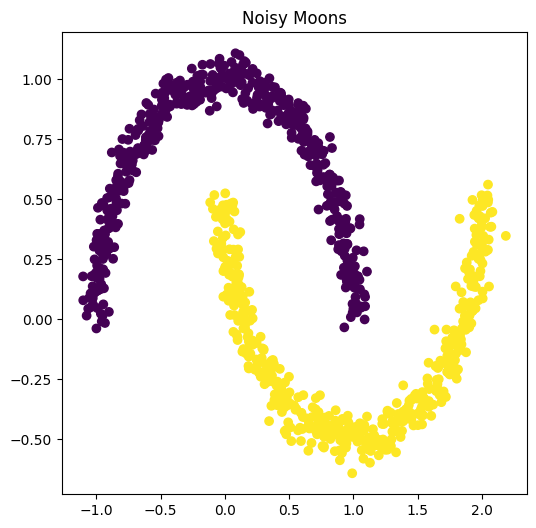

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

n_samples = 1000
n_genes = 100

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
X1, y1 = noisy_moons

proj = np.random.normal(size=(n_genes, 2))


plt.figure(figsize=(6, 6))
plt.scatter(X1[:, 0], X1[:, 1], c=y1, cmap='viridis')
plt.title('Noisy Moons')
plt.show()

X1 = np.dot(X1, proj.T)



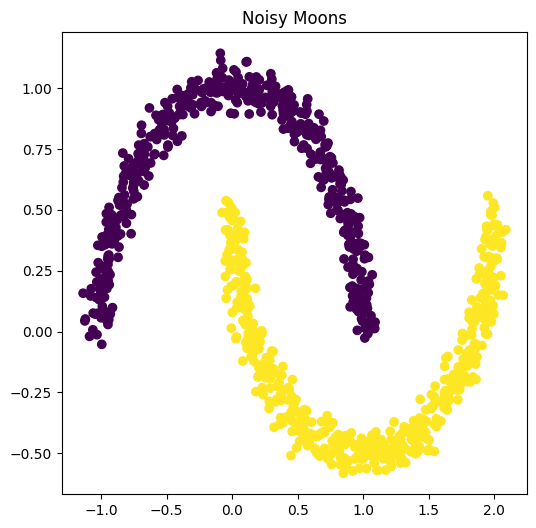

In [2]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

n_samples = 1000
n_genes = 100

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
X2, y2 = noisy_moons

proj = np.random.normal(size=(n_genes, 2))

plt.figure(figsize=(6, 6))
plt.scatter(X2[:, 0], X2[:, 1], c=y2, cmap='viridis')
plt.title('Noisy Moons')
plt.show()

X2 = np.dot(X2, proj.T)



In [3]:
import numpy
def total_correlation(X1, X2, k):
    r1 = 1e-4
    r2 = 1e-4

    n1 = X1.shape[1] 
    n2 = X2.shape[1]
    m = X1.shape[0] #number of rows

    mean1 = numpy.mean(X1, axis=0)
    mean2 = numpy.mean(X2, axis=0)

    H1bar = X1 - numpy.tile(mean1, (m, 1))
    H2bar = X2 - numpy.tile(mean2, (m, 1))


    SigmaHat12 = (1.0 / (m - 1)) * numpy.dot(H1bar.T, H2bar)
    SigmaHat11 = (1.0 / (m - 1)) * numpy.dot(H1bar.T, H1bar) + r1 * numpy.identity(n1)
    SigmaHat22 = (1.0 / (m - 1)) * numpy.dot(H2bar.T, H2bar) + r2 * numpy.identity(n2)


    [D1, V1] = numpy.linalg.eigh(SigmaHat11) #Eigendecomposition for easy inversion
    [D2, V2] = numpy.linalg.eigh(SigmaHat22) #Eigendecomposition for easy inversion
    SigmaHat11RootInv = numpy.dot(numpy.dot(V1, numpy.diag(D1 ** -0.5)), V1.T) #
    SigmaHat22RootInv = numpy.dot(numpy.dot(V2, numpy.diag(D2 ** -0.5)), V2.T)
    T = numpy.dot(numpy.dot(SigmaHat11RootInv, SigmaHat12), SigmaHat22RootInv)
    

    [U, D, V] = numpy.linalg.svd(T)
    V = V.T
    A1star = numpy.dot(SigmaHat11RootInv, U[:, 0:k])
    A2star = numpy.dot(SigmaHat22RootInv, V[:, 0:k])
    D = D[0:k]

    top_k_singular_values = D[:k]

    total_corr = numpy.sum(D)

    return A1star, total_corr, A2star

In [4]:
A1, total_corr, A2 = total_correlation(X1, X2, k=2)

In [5]:
total_corr

0.018072721163490825

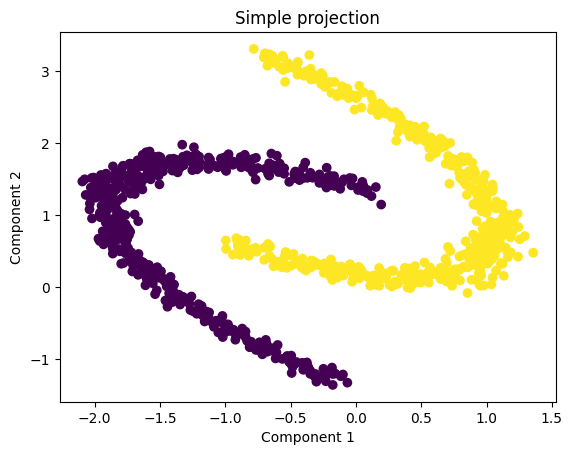

In [6]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.scatter((X1 @ A1)[:, 0], (X1 @ A1)[:, 1], c=y1)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Simple projection')
plt.show()


In [7]:
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff,2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

2023-07-13 10:59:04.021119: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:


import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout, LeakyReLU, BatchNormalization
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from dcca import  CCA
from keras.optimizers import Adam, RMSprop

def constant_loss(y_true, y_pred):
    return y_pred

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff,2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

#train_set_x1, valid_set_x1, train_set_x2, valid_set_x2 = train_test_split(X, Y, test_size=0.20)

# size of the input for view 1 and view 2
input_shape1 = 100
input_shape2 = 100

# network settings
epoch_num = 20


batch_size = 100
#load data


input1 = Input(shape=(input_shape1, ), name='input1')
input2 = Input(shape=(input_shape2, ), name='input2')

expert_index = 0
# Definicja funkcji aktywacji
activation_model ='relu'

# Warstwy wejściowe
input1 = Input(shape=(input_shape1,))
input2 = Input(shape=(input_shape2,))

# Warstwy gęste dla widoku 1
normalizaction_1 = BatchNormalization()(input1)
dense1_1 = Dense(10, name='view_1_1')(normalizaction_1)
rbg_1 = RBFLayer(10, 1)(dense1_1)
#dense1_2 = Dense(10, name='view_1_2')(rbg_1)
#rbg_2 = RBFLayer(10, 1)(dense1_2)
output1 = Dense(2, activation='linear', name='view_1_4')(rbg_1)

# Warstwy gęste dla widoku 2
normalizaction_2 = BatchNormalization()(input2)
dense2_1 = Dense(10, name='view_2_1')(normalizaction_2)
rbg_2 = RBFLayer(10, 1)(dense2_1)
#dense2_2 = Dense(10, name='view_2_2')(rbg_2)
#rbg_4 = RBFLayer(10, 1)(dense2_2)
output2 = Dense(2, activation='linear', name='view_2_4')(rbg_2)

# Warstwa łącząca
shared_layer = concatenate([output1, output2], name='shared_layer')

# Normalizacja danych
shared_layer = BatchNormalization()(shared_layer)

cca_layer = CCA(1, name='cca_layer')(shared_layer)

model = Model(inputs=[input1, input2], outputs=cca_layer)
model.compile(optimizer=RMSprop(lr=0.0001), loss=constant_loss, metrics=[mean_pred])
model.fit([X1, X2], np.zeros(len(X1)),
          batch_size=batch_size, epochs=epoch_num, shuffle=True, verbose=1)



Epoch 1/20
10/10 [==============================] - 2s 5ms/step - loss: -0.2159 - mean_pred: -0.2159
Epoch 2/20
10/10 [==============================] - 0s 7ms/step - loss: -0.2142 - mean_pred: -0.2142
Epoch 3/20
10/10 [==============================] - 0s 7ms/step - loss: -0.2457 - mean_pred: -0.2457
Epoch 4/20
10/10 [==============================] - 0s 7ms/step - loss: -0.2833 - mean_pred: -0.2833
Epoch 5/20
10/10 [==============================] - 0s 7ms/step - loss: -0.2518 - mean_pred: -0.2518
Epoch 6/20
10/10 [==============================] - 0s 7ms/step - loss: -0.2161 - mean_pred: -0.2161
Epoch 7/20
10/10 [==============================] - 0s 7ms/step - loss: -0.2252 - mean_pred: -0.2252
Epoch 8/20
10/10 [==============================] - 0s 7ms/step - loss: -0.2342 - mean_pred: -0.2342
Epoch 9/20
10/10 [==============================] - 0s 7ms/step - loss: -0.2130 - mean_pred: -0.2130
Epoch 10/20
10/10 [==============================] - 0s 6ms/step - loss: -0.2847 - mean_pre

In [30]:
current_dcca = Model(model.input, model.get_layer(name='shared_layer').output)


pred_out = current_dcca.predict([X1, X2])

32/32 [==============================] - 0s 1ms/step


In [31]:
X1.shape

(1000, 100)

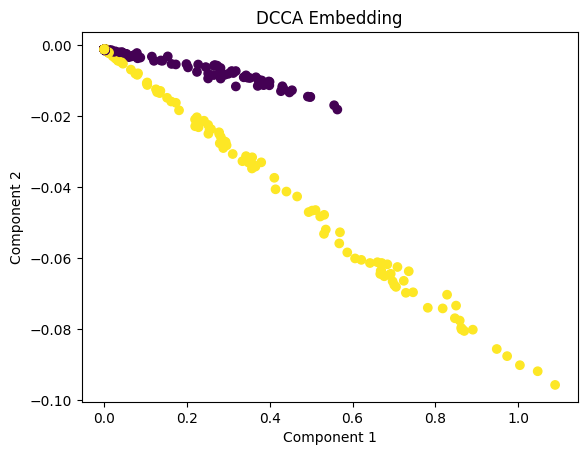

In [32]:
import matplotlib.pyplot as plt

plt.scatter(pred_out[:, 0], pred_out[:, 1], c=y1)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('DCCA Embedding')
plt.show()


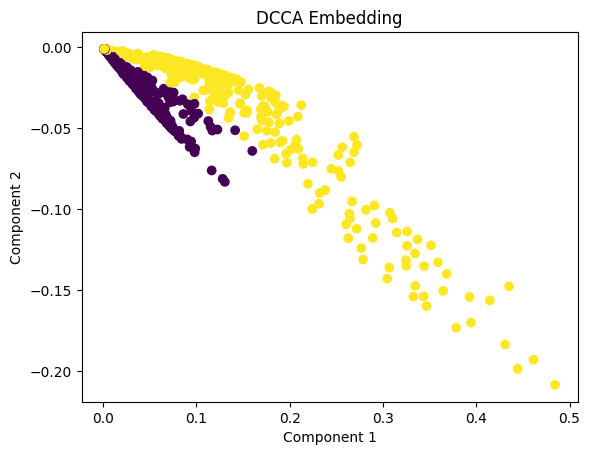

In [28]:
import matplotlib.pyplot as plt

plt.scatter(pred_out[:, 2], pred_out[:, 3], c=y2)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('DCCA Embedding')
plt.show()
